# BAF627 HW1 

20249433 MFE 최재필


In [91]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

import scipy.optimize as sco

from tqdm import tqdm

In [53]:
msf = pd.read_csv('msf.csv')
msp500_rf = pd.read_csv('msp500_risk_free.csv')

In [54]:
msf['mdate'] = pd.to_datetime(msf['mdate'])

In [55]:
msp500_rf['mdate'] = pd.to_datetime(msp500_rf['mdate'])

In [56]:
msf_ret = msf[['mdate', 'ticker', 'ret']].pivot(index='mdate', columns='ticker', values='ret')
msf_ret.tail()

ticker,AAPL,ABT,ADBE,ADI,ADP,ADSK,AIG,AMAT,AMD,AMGN,...,TMO,TXN,UNH,UNP,USB,VZ,WFC,WM,WMT,XOM
mdate,,,,,,,,,,,,,,,,,,,,,
2021-08-31,0.042438,0.044553,0.067677,-0.022578,-0.002815,-0.034379,0.152270,-0.032588,0.042659,-0.058996,...,0.027666,0.001521,0.009825,-0.003886,0.033309,-0.013983,-0.000871,0.046203,0.042792,-0.037867
2021-09-30,-0.068037,-0.065205,-0.132560,0.027800,-0.039179,-0.080364,0.011913,-0.047362,-0.070629,-0.057110,...,0.029985,0.006810,-0.057847,-0.096062,0.043736,-0.018000,0.015536,-0.033363,-0.058879,0.078870
2021-10-31,0.058657,0.094895,0.129646,0.035885,0.122899,0.113757,0.076517,0.061524,0.168416,-0.026711,...,0.108064,-0.018626,0.178456,0.231570,0.015646,-0.007036,0.102349,0.072777,0.072033,0.096056
2021-11-30,0.104940,-0.024207,0.029968,0.038965,0.028509,-0.199679,-0.109832,0.078888,0.317225,-0.030584,...,-0.000379,0.026083,-0.035290,-0.023861,-0.083320,-0.051330,-0.062158,0.002746,-0.058827,-0.058167
2021-12-31,0.074229,0.119027,-0.153452,-0.021026,0.072459,0.106220,0.087072,0.069094,-0.091368,0.131185,...,0.054786,-0.020273,0.133650,0.074138,0.023310,0.033618,0.004186,0.042354,0.032781,0.022560


In [57]:
sp500_s = msp500_rf[['mdate', 'spindx']].set_index('mdate')
sp500_ret = sp500_s.pct_change().dropna()

In [58]:
rf_s = msp500_rf[['mdate', 'rf']].set_index('mdate')

## 1. mean & covariance

- Assume there is no risk-free asset
- Short-selling is allowed

In [59]:
cov_df = msf_ret.cov()
mean_s = msf_ret.mean()

In [60]:
std_s = msf_ret.std()

In [61]:
cov_2d = cov_df.values
mean_v = mean_s.values
std_v = std_s.values

### (a) 

- Derive the mean-variance frontier using the standard deviation for measuring risk
- Plot the mean-variance frontier
- Indicate the global minimum portfolio (GMVP) on the plot

In [62]:
def port_mean(W, mean_v, rf=0):
    """Get the mean of the portfolio

    Args:
        W (np.ndarray): 1*n array of weights
        mean_v (np.ndarray): 1*n array of mean returns

    Returns:
        float: weighted mean return of the portfolio. (1, ) scalar
    """
    return np.dot(W, mean_v - rf)

In [63]:
# Test the function

n = len(mean_v)
W = np.ones((1, n)) / n

In [64]:
port_mean(W, mean_v) 

array([0.0146253])

In [65]:
def port_var(W, cov_2d):
    """Get the variance of the portfolio

    Args:
        W (np.ndarray): 1*n array of weights
        cov_2d (np.ndarray): n*n array of covariance matrix

    Returns:
        float: variance of the portfolio. (1, 1) array
    """    
    return np.dot(W, np.dot(cov_2d, W.T))

In [66]:
port_var(W, cov_2d)

array([[0.00194029]])

In [67]:
def negative_port_sharpe(W, mean_v, cov_2d):
    """Get the Sharpe ratio of the portfolio

    Args:
        W (np.ndarray): 1*n array of weights
        mean_v (np.ndarray): 1*n array of mean returns
        cov_2d (np.ndarray): n*n array of covariance matrix
        rf (float): risk-free rate

    Returns:
        float: Sharpe ratio of the portfolio. (1, 1) array
    """    
    return -1 * port_mean(W, mean_v) / np.sqrt(port_var(W, cov_2d))

In [68]:
negative_port_sharpe(W, mean_v, cov_2d)

array([[-0.33202557]])

In [69]:
def optimize_portfolio(mean_v, cov_2d):
    """Optimize the portfolio to get the maximum Sharpe ratio

    Args:
        mean_v (np.ndarray): 1*n array of mean returns
        cov_2d (np.ndarray): n*n array of covariance matrix
        rf (float): risk-free rate

    Returns:
        scipy.optimize.OptimizeResult: Result of the optimization
    """
    n = len(mean_v)
    args = (mean_v, cov_2d)
    constraints = {
        "type": "eq",
        "fun": lambda W: np.sum(W) - 1,
    }
    bounds = tuple((-1, 1) for asset in range(n))

    result = sco.minimize(
        negative_port_sharpe,  # Minimize the negative Sharpe ratio = maximize the Sharpe ratio
        n * [1.0 / n,],  # Initial guess
        args=args,  # asset returns, covariance matrix
        method="SLSQP",
        bounds=bounds,  # weights between -1 and 1
        constraints=constraints,  # weights sum to 1
    )

    return result

In [80]:
def optimize_portfolio_given_return(ret, mean_v, cov_2d):
    """Optimize the portfolio to get the maximum Sharpe ratio

    Args:
        mean_v (np.ndarray): 1*n array of mean returns
        cov_2d (np.ndarray): n*n array of covariance matrix
        rf (float): risk-free rate

    Returns:
        scipy.optimize.OptimizeResult: Result of the optimization
    """
    n = len(mean_v)
    args = (mean_v, cov_2d)
    constraints = [
        {"type": "eq", "fun": lambda W: np.sum(W) - 1,}, 
        {"type": "eq", "fun": lambda W: port_mean(W, mean_v) - ret,}
        ]
    bounds = tuple((-1, 1) for asset in range(n))

    result = sco.minimize(
        negative_port_sharpe,  # Minimize the negative Sharpe ratio = maximize the Sharpe ratio
        n * [1.0 / n,],  # Initial guess
        args=args,  # asset returns, covariance matrix
        method="SLSQP",
        bounds=bounds,  # weights between -1 and 1
        constraints=constraints,  # weights sum to 1
    )

    return result

In [70]:
optimize_portfolio(mean_v, cov_2d) # optimized result의 x가 optimal weights

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.6829405383191701
       x: [ 3.854e-02  4.338e-02 ...  2.784e-02  1.427e-02]
     nit: 24
     jac: [-1.634e-04 -6.087e-06 ... -7.312e-05 -2.859e-04]
    nfev: 2452
    njev: 24

In [82]:
def get_opportunity_set(mean_v, cov_2d, num_portfolios=100):
    """Get the opportunity set by generating random portfolios

    Args:
        mean_v (np.ndarray): 1*n array of mean returns
        cov_2d (np.ndarray): n*n array of covariance matrix
        num_portfolios (int): number of random portfolios to generate

    Returns:
        np.ndarray: 3 * num_portfolios array of results // (portfolio return, portfolio std, portfolio sharpe ratio)
        list: list of weights
    """

    results = np.zeros((3, num_portfolios))
    weights_record = []

    for i in range(num_portfolios):
        weights = np.random.uniform(-1, 1, len(mean_v))
        weights /= np.sum(np.abs(weights))
        # TODO: Weights don't sum to 1. If normalized, the resulting efficient frontier breaks.

        p_ret, p_std = port_mean(weights, mean_v), np.sqrt(port_var(weights, cov_2d))
        results[0, i] = p_ret
        results[1, i] = p_std
        results[2, i] = p_ret / p_std

        weights_record.append(weights)
    
    return results, weights_record
    

In [92]:
def get_efficient_frontier(mean_v, cov_2d, return_range=[-0.1, 0.1], num_portfolios=100):
    """Get the efficient frontier by optimizing the portfolio for each return given the range

    Args:
        mean_v (np.ndarray): 1*n array of mean returns
        cov_2d (np.ndarray): n*n array of covariance matrix
        return_range (list): range of return to optimize the portfolio
        num_portfolios (int): number of portfolios to generate

    Returns:
        np.ndarray: 3 * num_portfolios array of results // (portfolio return, portfolio std, portfolio sharpe ratio)
        list: list of weights
    """
    weights_record = []

    min_ret, max_ret = return_range
    ret_range = np.linspace(min_ret, max_ret, num_portfolios)
    results = np.zeros((3, len(ret_range)))

    for i, ret in enumerate(tqdm(ret_range, desc=f'Calculating optimum weights in range {min_ret} to {max_ret} for {num_portfolios} portfolios')):
        result = optimize_portfolio_given_return(ret, mean_v, cov_2d)
        weights = result.x

        p_ret, p_std = port_mean(weights, mean_v), np.sqrt(port_var(weights, cov_2d))
        results[0, i] = p_ret
        results[1, i] = p_std
        results[2, i] = p_ret / p_std

        weights_record.append(weights)
        
    return results, weights_record
    

In [84]:
results, weights_record = get_opportunity_set(mean_v, cov_2d, num_portfolios=100)

In [85]:
# Tangent portfolio
max_sharpe_idx = np.argmax(results[2])
tangent_p_std, tangent_p_ret = results[1, max_sharpe_idx], results[0, max_sharpe_idx]

# Global minimum variance portfolio
min_vol_idx = np.argmin(results[1])
gmvp_std, gmvp_ret = results[1, min_vol_idx], results[0, min_vol_idx]



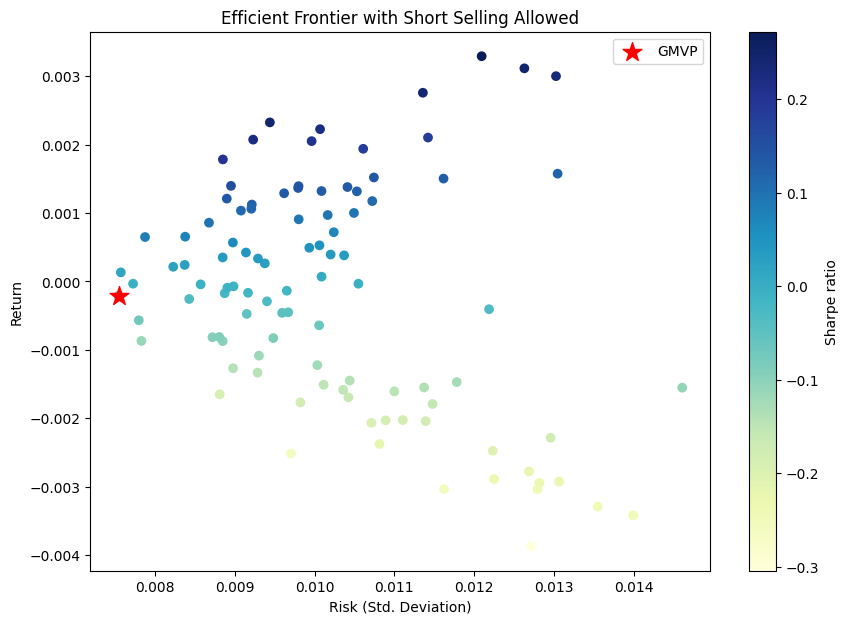

In [86]:

# Plot the efficient frontier
plt.figure(figsize=(10, 7))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='YlGnBu', marker='o')
plt.colorbar(label='Sharpe ratio')
plt.scatter(gmvp_std, gmvp_ret, marker='*', color='r', s=200, label='GMVP')
plt.title('Efficient Frontier with Short Selling Allowed')
plt.xlabel('Risk (Std. Deviation)')
plt.ylabel('Return')
plt.legend(labelspacing=0.8)
plt.show()


In [93]:
results, weights_record = get_efficient_frontier(mean_v, cov_2d, num_portfolios=10)

Calculating optimum weights in range -0.1 to 0.1 for 10 portfolios:   0%|          | 0/10 [00:00<?, ?it/s]

Calculating optimum weights in range -0.1 to 0.1 for 10 portfolios: 100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


In [94]:
# Tangent portfolio
max_sharpe_idx = np.argmax(results[2])
tangent_p_std, tangent_p_ret = results[1, max_sharpe_idx], results[0, max_sharpe_idx]

# Global minimum variance portfolio
min_vol_idx = np.argmin(results[1])
gmvp_std, gmvp_ret = results[1, min_vol_idx], results[0, min_vol_idx]



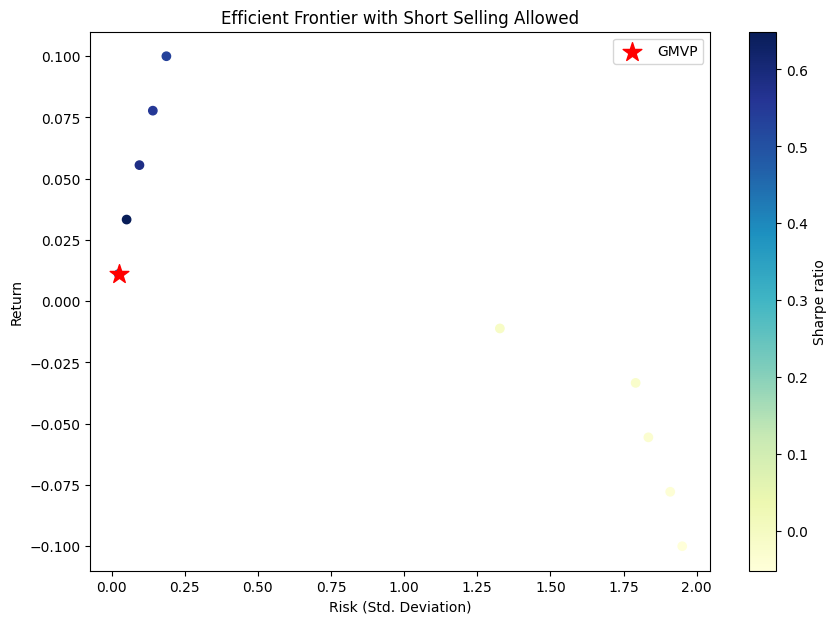

In [95]:

# Plot the efficient frontier
plt.figure(figsize=(10, 7))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='YlGnBu', marker='o')
plt.colorbar(label='Sharpe ratio')
plt.scatter(gmvp_std, gmvp_ret, marker='*', color='r', s=200, label='GMVP')
plt.title('Efficient Frontier with Short Selling Allowed')
plt.xlabel('Risk (Std. Deviation)')
plt.ylabel('Return')
plt.legend(labelspacing=0.8)
plt.show()


In [75]:
## Sum = 1이 되는 (-1, 1) 사이의 weights 생성

def generate_random_weights(size):
    # Step 1: Generate random weights with values between -1 and 1
    weights = np.random.uniform(-1, 1, size)
    
    # Step 2: Compute the sum of the absolute values of these weights
    abs_sum = np.sum(np.abs(weights))
    
    # Step 3: Normalize the weights by dividing each weight by the sum of the absolute values
    normalized_weights = weights / abs_sum
    
    # Ensure the sum of weights is exactly 1
    normalized_weights = normalized_weights / np.sum(normalized_weights)
    
    return normalized_weights

# Example usage
weights = generate_random_weights(1000)
negative_weights_count = (weights < 0).sum()
weights_sum = np.sum(weights)
weights[:10], negative_weights_count, weights_sum


(array([ 0.02899985, -0.02860115, -0.03237808, -0.01293319, -0.01355051,
         0.03232046,  0.00799272,  0.03493762,  0.00189137,  0.01828133]),
 467,
 0.9999999999999999)